### Peer-graded Assignment: 
# Segmenting and Clustering Neighborhoods in Toronto

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

from bs4 import BeautifulSoup
#import geocoder # import geocoder

print('Libraries imported.')

Libraries imported.


## Extracting the Neighborhood information from Wikipedia table

In [3]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

df = pd.read_html(url)[0]
html_doc = requests.get(url)
soup = BeautifulSoup(html_doc.text, 'html.parser')

Processing the extracted HTML data to further acquire the Postal Code, Borough and Neighborhood information.

In [5]:
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

# The four boroughts listed above seems to have an unusually long or awkward name.  Resetting them back to their more locally known names.

In [6]:
# Checking the result of the scrape
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


In [7]:
df.shape

(103, 3)

## Adding Lang and Long

In [8]:
# GeoCoder method did not work - proceeding with CSV

#!pip install geocoder
#import geocoder # import geocoder
#df['Latitude'] = None
#df['Longitude'] = None
#df.head()

'''for postal in df['PostalCode']:
  lat_lng_coords = None

# loop until you get the coordinates
  while(lat_lng_coords is None):
    g = geocoder.google('{}, Toronto, Ontario'.format(postal))
    lat_lng_coords = g.latlng

  df['Latitude'] = lat_lng_coords[0]
  df['longitude'] = lat_lng_coords[1]'''

"for postal in df['PostalCode']:\n  lat_lng_coords = None\n\n# loop until you get the coordinates\n  while(lat_lng_coords is None):\n    g = geocoder.google('{}, Toronto, Ontario'.format(postal))\n    lat_lng_coords = g.latlng\n\n  df['Latitude'] = lat_lng_coords[0]\n  df['longitude'] = lat_lng_coords[1]"

In [9]:
# Extracting CSV with Long Lat information
lat_long = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv')  
print(lat_long.head())
print(lat_long.shape)

  Postal Code   Latitude  Longitude
0         M1B  43.806686 -79.194353
1         M1C  43.784535 -79.160497
2         M1E  43.763573 -79.188711
3         M1G  43.770992 -79.216917
4         M1H  43.773136 -79.239476
(103, 3)


In [10]:
# Merge the scraped data with the long and lat data
df_toronto = df.merge(lat_long, left_on='PostalCode', right_on='Postal Code').drop(['Postal Code'], axis=1)
df_toronto.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


In [11]:
# Acquire the geographical coordinate for Toronto (Downtown Toronto)
address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [12]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='purple',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [13]:
CLIENT_ID = 'X' # your Foursquare ID
CLIENT_SECRET = 'X' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [15]:
# Getting Venue information based on Neighborhoods using FourSquare API
toronto_venues = getNearbyVenues(df_toronto['Neighborhood'], df_toronto['Latitude'], df_toronto['Longitude'])

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills North
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview East
The Danforth

In [16]:
# Examining the result of the Venue API call
print(toronto_venues.shape)
toronto_venues.head()

(2119, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
2,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


In [17]:
toronto_venues.groupby('Neighborhood').count()['Venue']

Neighborhood
Agincourt                                                                                                                                   4
Alderwood, Long Branch                                                                                                                      7
Bathurst Manor, Wilson Heights, Downsview North                                                                                            22
Bayview Village                                                                                                                             4
Bedford Park, Lawrence Manor East                                                                                                          28
Berczy Park                                                                                                                                60
Birch Cliff, Cliffside West                                                                                                            

In [18]:
print('There are {} unique categories.'.format(len(toronto_venues['Venue Category'].unique())))
df_tv = toronto_venues

There are 269 unique categories.


In [19]:
# Performing One-Hot encoding to explore venue categories
toronto_onehot = pd.get_dummies(df_tv[['Venue Category']], prefix="", prefix_sep="")

# adding neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood']
# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Carpet Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Knitting Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [20]:
toronto_onehot.shape

(2119, 269)

In [21]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
#toronto_grouped
toronto_grouped.shape

(100, 269)

In [22]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [23]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Latin American Restaurant,Skating Rink,Lounge,Breakfast Spot,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
1,"Alderwood, Long Branch",Pizza Place,Gym,Skating Rink,Pub,Sandwich Place,Coffee Shop,General Travel,General Entertainment,Donut Shop,Doner Restaurant
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Shopping Mall,Frozen Yogurt Shop,Ice Cream Shop,Supermarket,Intersection,Sushi Restaurant,Restaurant,Middle Eastern Restaurant
3,Bayview Village,Chinese Restaurant,Café,Bank,Japanese Restaurant,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Women's Store
4,"Bedford Park, Lawrence Manor East",Italian Restaurant,Coffee Shop,Sandwich Place,Restaurant,Spa,Fast Food Restaurant,Pub,Butcher,Café,Sushi Restaurant


# Clustering

In [24]:
import matplotlib.pyplot as plt

(array([82.,  0., 13.,  0.,  0.,  1.,  0.,  2.,  0.,  2.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

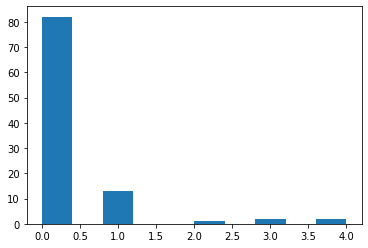

In [51]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
# setting random state to stabilise the results for the assignment
kmeans = KMeans(n_clusters=kclusters, random_state=1).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
plt.hist(kmeans.labels_, bins=10)

In [52]:
# add clustering labels
#neighborhoods_venues_sorted = neighborhoods_venues_sorted.drop('Cluster Labels', axis=1)
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_toronto

# merge toronto_grouped with toronto data (df_toronto) to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].replace(np.nan, -1)
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype(int)

toronto_merged.head() # check the last columns!

ValueError: ignored

In [53]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters

## Cluster - 0
This cluster seems to have been formed due to the prominance of fast food and dim sum restaurants. 


In [54]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Parkwoods,0,Park,Fast Food Restaurant,Food & Drink Shop,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run
6,"Malvern, Rouge",0,Fast Food Restaurant,Women's Store,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop
27,Hillcrest Village,0,Dog Run,Pool,Golf Course,Fast Food Restaurant,Mediterranean Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
56,"Del Ray, Mount Dennis, Keelsdale and Silverthorn",0,Fast Food Restaurant,Sandwich Place,Discount Store,Women's Store,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Distribution Center,Doner Restaurant


## Cluster - 1
Cluster 1 seems to form around the baseball field and dim sum restaurants.

In [55]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
53,Downsview Central,1,Baseball Field,Food Truck,Women's Store,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Event Space
57,"Humberlea, Emery",1,Baseball Field,Women's Store,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Falafel Restaurant
101,"Old Mill South, King's Mill Park, Sunnylea, Hu...",1,Park,Baseball Field,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Event Space


## Cluster - 2
Cluster 2 seems to contain the majority of the venue entries as it contains a good mix of restaurants and coffee shops.

In [56]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Victoria Village,2,Portuguese Restaurant,Coffee Shop,Intersection,Pizza Place,Hockey Arena,Women's Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
2,"Regent Park, Harbourfront",2,Coffee Shop,Bakery,Café,Park,Pub,Breakfast Spot,Theater,Restaurant,Dessert Shop,Chocolate Shop
3,"Lawrence Manor, Lawrence Heights",2,Clothing Store,Furniture / Home Store,Carpet Store,Accessories Store,Boutique,Vietnamese Restaurant,Coffee Shop,Miscellaneous Shop,Women's Store,Dessert Shop
4,Ontario Provincial Government,2,Coffee Shop,Sushi Restaurant,Gym,Distribution Center,Sandwich Place,Portuguese Restaurant,Park,Mexican Restaurant,Japanese Restaurant,Italian Restaurant
7,Don Mills North,2,Gym,Café,Dessert Shop,Caribbean Restaurant,Japanese Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
8,"Parkview Hill, Woodbine Gardens",2,Pizza Place,Bank,Gym / Fitness Center,Intersection,Athletics & Sports,Pet Store,Pharmacy,Gastropub,Café,Flea Market
9,"Garden District, Ryerson",2,Coffee Shop,Clothing Store,Cosmetics Shop,Bubble Tea Shop,Middle Eastern Restaurant,Café,Japanese Restaurant,Theater,Electronics Store,Pizza Place
10,Glencairn,2,Sushi Restaurant,Park,Bakery,Pizza Place,Japanese Restaurant,Women's Store,Distribution Center,Dessert Shop,Dim Sum Restaurant,Diner
12,"Rouge Hill, Port Union, Highland Creek",2,Bar,Women's Store,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Falafel Restaurant
13,Don Mills South,2,Gym,Coffee Shop,Restaurant,Asian Restaurant,Grocery Store,Italian Restaurant,Discount Store,Dim Sum Restaurant,Chinese Restaurant,Sandwich Place


## Cluster - 3
Cluster 3 seems to have been formed around the playground.

In [57]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
32,Scarborough Village,3,Playground,Women's Store,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant


## Cluster - 4
Cluster 4 is is focused around Parks and dog runs.

In [58]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,Caledonia-Fairbanks,4,Park,Bar,Women's Store,Adult Boutique,Event Space,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore
35,The Danforth East,4,Park,Convenience Store,Intersection,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Department Store
52,"Willowdale, Newtonbrook",4,Park,Dance Studio,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run,Distribution Center
64,Weston,4,Park,Dance Studio,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run,Distribution Center
66,York Mills West,4,Park,Construction & Landscaping,Convenience Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Deli / Bodega
91,Rosedale,4,Park,Playground,Trail,Dumpling Restaurant,Drugstore,Donut Shop,Eastern European Restaurant,Doner Restaurant,Dog Run,Curling Ice


## NaN Cluster
This is technically not a cluster but rather leftover data.  It seems like these three neighborhoods do not have any venues associated with them within them.

In [59]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == -1, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Islington Avenue,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,"West Deane Park, Princess Gardens, Martin Grov...",-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,Upper Rouge,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
